In [ ]:
import trimesh
import torch
import mcubes
import numpy as np
from skgstat import Variogram
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
device = 'cuda'
pth_file = 'experiments/suzanne/set100/models/M0.pth'
nerf_model = torch.load(pth_file).to(device)

# Generate the grid of points for XYZ
N = 30
scale = 1.5
x = torch.linspace(-scale, scale, N, device=device)
y = torch.linspace(-scale, scale, N, device=device)
z = torch.linspace(-scale, scale, N, device=device)
x, y, z = torch.meshgrid((x, y, z))
xyz = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)), dim=1)  # [125000, 3] points
xyzDirection = torch.zeros_like(xyz).to(device)

In [ ]:
# Generate densities
_, density = nerf_model.forward(xyz, xyzDirection)  # [125000]
density = density.cpu().detach().numpy()  # Convert to numpy array
xyz = xyz.cpu().detach().numpy()  # Convert to numpy array

# Apply masking to reduce the number of points
threshold_value = np.quantile(density, 0.5)  # Use median density as threshold
mask = density >= threshold_value  # Mask for high-density points

# Additional mask (e.g., only points with positive z-values)
z_positive_mask = xyz[:, 2] >= 0
combined_mask = mask & z_positive_mask

# Filter points and density using the mask
filtered_xyz = xyz[combined_mask]
filtered_density = density[combined_mask]

filtered_xyz_scaled = (filtered_xyz / N) * (2 * scale) - scale

In [ ]:
# Compute the variogram using the filtered and scaled points
variogram = Variogram(
    filtered_xyz, 
    filtered_density, 
    model='spherical', 
    normalize=False, 
    nugget=0.1
)

# Describe the fitted variogram
print(variogram.describe())

# Plot the variogram
variogram.plot()
plt.title("3D Variogram for Filtered NeRF Densities")
plt.show()

In [ ]:
from scipy.spatial.distance import pdist, squareform

pairwise_distances = squareform(pdist(filtered_xyz))  # [5080, 5080]

# Get the bin edges and experimental variogram values
bin_edges = variogram.bins  # Bin edges (distance ranges)
bin_uncertainties = variogram.experimental  # Semi-variance per bin

# Initialize uncertainties for each point
point_uncertainties = np.zeros(filtered_xyz.shape[0])

# Assign uncertainties based on the average bin of the point's neighbors
for i in range(filtered_xyz.shape[0]):
    # Find distances from the current point
    distances = pairwise_distances[i]
    
    # Find which bin each distance falls into
    bin_indices = np.digitize(distances, bin_edges, right=True)
    
    # Assign the uncertainty as the average uncertainty of its neighbors' bins
    neighbor_uncertainties = bin_uncertainties[bin_indices - 1]  # Adjust index
    point_uncertainties[i] = np.mean(neighbor_uncertainties)

# Normalize point uncertainties
point_uncertainties = (point_uncertainties - np.min(point_uncertainties)) / (
    np.max(point_uncertainties) - np.min(point_uncertainties)
)

# assert len(uncertainty) == len(filtered_xyz) 
# print(len(uncertainty)); print(len(filtered_xyz))
# Assign colors based on uncertainty using a colormap
colormap = cm.get_cmap('inferno')
colors = colormap(point_uncertainties)[:, :3]  # Get RGB values

# Create a PointCloud with colors
point_cloud = trimesh.points.PointCloud(filtered_xyz, colors=colors)

In [ ]:

# Define the uncertainty threshold (e.g., 0.5)
threshold = 0.5

# Filter points, uncertainties, and colors based on the threshold
threshold_mask = point_uncertainties >= threshold  # Keep points with uncertainty >= threshold
filtered_xyz_thresholded = filtered_xyz[threshold_mask]
point_uncertainties_thresholded = point_uncertainties[threshold_mask]
colors_thresholded = colors[threshold_mask]

# Define sphere sizes for the remaining points
sphere_sizes_thresholded = 0.05 + point_uncertainties_thresholded * 0.01
# Create spheres for the thresholded points
spheres = []
for point, size, color in zip(filtered_xyz_thresholded, sphere_sizes_thresholded, colors_thresholded):
    sphere = trimesh.primitives.Sphere(
        radius=size, center=point, subdivisions=2  # Subdivisions for smoothness
    )
    # Apply the color to the sphere
    sphere.visual.vertex_colors = (color * 255).astype(np.uint8)
    spheres.append(sphere)

# Add the spheres and the mesh to the scene
density_np = density.reshape(N, N, N)
vertices, triangles = mcubes.marching_cubes(density_np, 5 * np.mean(density_np))
vertices_scaled = (vertices / N) * (2 * scale) - scale
mesh = trimesh.Trimesh(vertices_scaled, triangles)
scene = trimesh.Scene([mesh] + spheres)

# Show the scene
scene.show()

In [ ]:
# density_np = density.reshape(N, N, N)
# vertices, triangles = mcubes.marching_cubes(density_np, 5 * np.mean(density_np))
# vertices_scaled = (vertices / N) * (2 * scale) - scale
# mesh = trimesh.Trimesh(vertices_scaled, triangles)
# scene = trimesh.Scene([mesh, point_cloud])
# scene.show()


# Attempting Color-based Variogram

In [ ]:
import trimesh
import torch
import mcubes
import numpy as np
from skgstat import Variogram
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist, squareform

device = 'cuda'
pth_file = 'experiments/suzanne/set100/models/M0.pth'
# pth_file = "experiments/test/set30/models/M0.pth"
nerf_model = torch.load(pth_file).to(device)

# Generate the grid of points for XYZ
N = 35
scale = 1.5
x = torch.linspace(-scale, scale, N, device=device)
y = torch.linspace(-scale, scale, N, device=device)
z = torch.linspace(-scale, scale, N, device=device)
x, y, z = torch.meshgrid((x, y, z))
xyz = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)), dim=1)  # [125000, 3] points

# Define a view direction for color queries (e.g., along the z-axis)
view_direction = torch.tensor([0, 0, 1], device=device).expand(xyz.shape[0], -1)

# Query the NeRF model for colors (assumes `forward` outputs RGB and density)
rgb, _ = nerf_model.forward(xyz, view_direction)  # [125000, 3]

# Convert to numpy for processing
xyz = xyz.cpu().detach().numpy()
rgb = rgb.cpu().detach().numpy()

# Apply masking to reduce the number of points
threshold_value = np.quantile(rgb.mean(axis=1), 0.5)  # Use median RGB intensity as threshold
mask = rgb.mean(axis=1) >= threshold_value  # Mask based only on RGB intensity

# Filter points and colors using the mask
filtered_xyz = xyz[mask]
filtered_rgb = rgb[mask]

# Compute the variogram for color
color_variogram = Variogram(
    filtered_xyz, 
    filtered_rgb.mean(axis=1),  # Use mean intensity as a scalar representation of color
    model='spherical', 
    normalize=False, 
    nugget=0.1
)

# Describe the fitted variogram
print(color_variogram.describe())

# Plot the variogram
color_variogram.plot()
plt.title("3D Variogram for Filtered NeRF Colors")
plt.show()

# Compute pairwise distances between points
pairwise_distances = squareform(pdist(filtered_xyz))  # [N, N]

# Get the bin edges and experimental variogram values
bin_edges = color_variogram.bins  # Bin edges (distance ranges)
bin_uncertainties = color_variogram.experimental  # Semi-variance per bin

# Initialize uncertainties for each point
point_uncertainties = np.zeros(filtered_xyz.shape[0])

# Assign uncertainties based on the average bin of the point's neighbors
for i in range(filtered_xyz.shape[0]):
    # Find distances from the current point
    distances = pairwise_distances[i]
    
    # Find which bin each distance falls into
    bin_indices = np.digitize(distances, bin_edges, right=True)
    
    # Assign the uncertainty as the average uncertainty of its neighbors' bins
    neighbor_uncertainties = bin_uncertainties[bin_indices - 1]  # Adjust index
    point_uncertainties[i] = np.mean(neighbor_uncertainties)

# Normalize point uncertainties
point_uncertainties = (point_uncertainties - np.min(point_uncertainties)) / (
    np.max(point_uncertainties) - np.min(point_uncertainties)
)

# Assign colors based on uncertainty using a colormap
colormap = cm.get_cmap('inferno')
colors = colormap(point_uncertainties)[:, :3]  # Get RGB values

# Create a PointCloud with colors
point_cloud = trimesh.points.PointCloud(filtered_xyz, colors=colors)

# Define the uncertainty threshold (e.g., 0.5)
threshold = 0.99

# Filter points, uncertainties, and colors based on the threshold
threshold_mask = point_uncertainties >= threshold  # Keep points with uncertainty >= threshold
filtered_xyz_thresholded = filtered_xyz[threshold_mask]
point_uncertainties_thresholded = point_uncertainties[threshold_mask]
colors_thresholded = colors[threshold_mask]

# Define sphere sizes for the remaining points
sphere_sizes_thresholded = 0.05 + point_uncertainties_thresholded * 0.001
# Create spheres for the thresholded points
spheres = []
for point, size, color in zip(filtered_xyz_thresholded, sphere_sizes_thresholded, colors_thresholded):
    sphere = trimesh.primitives.Sphere(
        radius=size, center=point, subdivisions=2  # Subdivisions for smoothness
    )
    # Apply the color to the sphere
    sphere.visual.vertex_colors = (color * 255).astype(np.uint8)
    spheres.append(sphere)

# Add the spheres and the mesh to the scene
density_np = rgb.mean(axis=1).reshape(N, N, N)  # Example for visualization
vertices, triangles = mcubes.marching_cubes(density_np, 3 * np.mean(density_np))
vertices_scaled = (vertices / N) * (2 * scale) - scale
mesh = trimesh.Trimesh(vertices_scaled, triangles)
scene = trimesh.Scene([mesh] + spheres)

# Show the scene
scene.show()


# What happens if we filter based on the density gradient?

In [ ]:
import trimesh
import torch
import mcubes
import numpy as np
from skgstat import Variogram
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist, squareform

device = 'cuda'
pth_file = 'experiments/suzanne/set100/models/M0.pth'
nerf_model = torch.load(pth_file).to(device)

# Generate the grid of points for XYZ
N = 35
scale = 1.5
x = torch.linspace(-scale, scale, N, device=device)
y = torch.linspace(-scale, scale, N, device=device)
z = torch.linspace(-scale, scale, N, device=device)
x, y, z = torch.meshgrid((x, y, z))
xyz = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)), dim=1).to(device)  # [N^3, 3]
xyz.requires_grad_(True)  # Ensure gradients for density gradient computation

# Define a view direction for color queries (e.g., along the z-axis)
view_direction = torch.tensor([0, 0, 1], device=device).expand(xyz.shape[0], -1)

# Query the NeRF model for colors and density
rgb, density = nerf_model.forward(xyz, view_direction)  # RGB: [N^3, 3], Density: [N^3]

# Compute the density gradient
density_gradient = torch.autograd.grad(
    outputs=density,
    inputs=xyz,
    grad_outputs=torch.ones_like(density),  # Same shape as density
    create_graph=True,
)[0]  # [N^3, 3]

# Calculate gradient magnitude
gradient_magnitude = torch.norm(density_gradient, dim=-1)  # [N^3]

# Apply the gradient magnitude mask
threshold = 3  # Define your threshold value
gradient_mask = gradient_magnitude >= threshold

# Filter points and attributes based on the mask
filtered_xyz = xyz[gradient_mask].cpu().detach().numpy()
filtered_rgb = rgb[gradient_mask].cpu().detach().numpy()
filtered_density = density[gradient_mask].cpu().detach().numpy()

# Compute the variogram for color
color_variogram = Variogram(
    filtered_xyz, 
    filtered_rgb.mean(axis=1),  # Use mean intensity as a scalar representation of color
    model='spherical', 
    normalize=False, 
    nugget=0.1
)

# Describe the fitted variogram
print(color_variogram.describe())

# Plot the variogram
color_variogram.plot()
plt.title("3D Variogram for Filtered NeRF Colors")
plt.show()

# Compute pairwise distances between points
pairwise_distances = squareform(pdist(filtered_xyz))  # [N_filtered, N_filtered]

# Get the bin edges and experimental variogram values
bin_edges = color_variogram.bins  # Bin edges (distance ranges)
bin_uncertainties = color_variogram.experimental  # Semi-variance per bin

# Initialize uncertainties for each point
point_uncertainties = np.zeros(filtered_xyz.shape[0])

# Assign uncertainties based on the average bin of the point's neighbors
for i in range(filtered_xyz.shape[0]):
    # Find distances from the current point
    distances = pairwise_distances[i]
    
    # Find which bin each distance falls into
    bin_indices = np.digitize(distances, bin_edges, right=True)
    
    # Assign the uncertainty as the average uncertainty of its neighbors' bins
    neighbor_uncertainties = bin_uncertainties[bin_indices - 1]  # Adjust index
    point_uncertainties[i] = np.mean(neighbor_uncertainties)

# Normalize point uncertainties
point_uncertainties = (point_uncertainties - np.min(point_uncertainties)) / (
    np.max(point_uncertainties) - np.min(point_uncertainties)
)

# Assign colors based on uncertainty using a colormap
colormap = cm.get_cmap('inferno')
colors = colormap(point_uncertainties)[:, :3]  # Get RGB values

# Define an uncertainty threshold
threshold_uncertainty = 0.9  # Adjust this value to filter spheres

# Filter points, sizes, and colors based on the uncertainty threshold
threshold_mask = point_uncertainties >= threshold_uncertainty
filtered_xyz_thresholded = filtered_xyz[threshold_mask]
point_uncertainties_thresholded = point_uncertainties[threshold_mask]
colors_thresholded = colors[threshold_mask]
sphere_sizes_thresholded = 0.05 + point_uncertainties_thresholded * 0.001  # Adjust size based on uncertainty

# Create spheres for the filtered points
spheres = []
for point, size, color in zip(filtered_xyz_thresholded, sphere_sizes_thresholded, colors_thresholded):
    sphere = trimesh.primitives.Sphere(
        radius=size, center=point, subdivisions=2  # Subdivisions for smoothness
    )
    # Apply the color to the sphere
    sphere.visual.vertex_colors = (color * 255).astype(np.uint8)
    spheres.append(sphere)


# Add the mesh for spatial context
density_np = density.cpu().detach().numpy().reshape(N, N, N)  # Use the full density array
vertices, triangles = mcubes.marching_cubes(density_np, 3 * np.mean(density_np))  # Adjust threshold as needed
vertices_scaled = (vertices / N) * (2 * scale) - scale
mesh = trimesh.Trimesh(vertices_scaled, triangles)

# Combine the mesh and spheres into a single scene
scene = trimesh.Scene([mesh] + spheres)

# Show the combined scene
scene.show()


# Just density gradient based didn't work well. What about filtering the points with sufficently high densities and gradients?

In [ ]:
import trimesh
import torch
import mcubes
import numpy as np
from skgstat import Variogram
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist, squareform

device = 'cuda'
pth_file = 'experiments/suzanne/set100/models/M0.pth'
nerf_model = torch.load(pth_file).to(device)

# Generate the grid of points for XYZ
N = 35
scale = 1.5
x = torch.linspace(-scale, scale, N, device=device)
y = torch.linspace(-scale, scale, N, device=device)
z = torch.linspace(-scale, scale, N, device=device)
x, y, z = torch.meshgrid((x, y, z))
xyz = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)), dim=1).to(device)  # [N^3, 3]
xyz.requires_grad_(True)  # Ensure gradients for density gradient computation

# Define a view direction for color queries (e.g., along the z-axis)
view_direction = torch.tensor([0, 0, 1], device=device).expand(xyz.shape[0], -1)

# Query the NeRF model for colors and density
rgb, density = nerf_model.forward(xyz, view_direction)  # RGB: [N^3, 3], Density: [N^3]

# Compute the density gradient
density_gradient = torch.autograd.grad(
    outputs=density,
    inputs=xyz,
    grad_outputs=torch.ones_like(density),  # Same shape as density
    create_graph=True,
)[0]  # [N^3, 3]

# Calculate gradient magnitude
gradient_magnitude = torch.norm(density_gradient, dim=-1)  # [N^3]

# Apply a combined mask for density and gradient magnitude
gradient_threshold = 2  # Threshold for gradient magnitude
density_threshold = 0.5 * density.max()  # Threshold for density (e.g., 50% of max density)

combined_mask = (gradient_magnitude >= gradient_threshold) & (density >= density_threshold)

# Filter points and attributes based on the combined mask
filtered_xyz = xyz[combined_mask].cpu().detach().numpy()
filtered_rgb = rgb[combined_mask].cpu().detach().numpy()
filtered_density = density[combined_mask].cpu().detach().numpy()

# Compute the variogram for color
color_variogram = Variogram(
    filtered_xyz, 
    filtered_rgb.mean(axis=1),  # Use mean intensity as a scalar representation of color
    model='spherical', 
    normalize=False, 
    nugget=0.1
)

# Describe the fitted variogram
print(color_variogram.describe())

# Plot the variogram
color_variogram.plot()
plt.title("3D Variogram for Filtered NeRF Colors")
plt.show()

# Compute pairwise distances between points
pairwise_distances = squareform(pdist(filtered_xyz))  # [N_filtered, N_filtered]

# Get the bin edges and experimental variogram values
bin_edges = color_variogram.bins  # Bin edges (distance ranges)
bin_uncertainties = color_variogram.experimental  # Semi-variance per bin

# Initialize uncertainties for each point
point_uncertainties = np.zeros(filtered_xyz.shape[0])

# Assign uncertainties based on the average bin of the point's neighbors
for i in range(filtered_xyz.shape[0]):
    # Find distances from the current point
    distances = pairwise_distances[i]
    
    # Find which bin each distance falls into
    bin_indices = np.digitize(distances, bin_edges, right=True)
    
    # Assign the uncertainty as the average uncertainty of its neighbors' bins
    neighbor_uncertainties = bin_uncertainties[bin_indices - 1]  # Adjust index
    point_uncertainties[i] = np.mean(neighbor_uncertainties)

# Normalize point uncertainties
point_uncertainties = (point_uncertainties - np.min(point_uncertainties)) / (
    np.max(point_uncertainties) - np.min(point_uncertainties)
)

# Assign colors based on uncertainty using a colormap
colormap = cm.get_cmap('inferno')
colors = colormap(point_uncertainties)[:, :3]  # Get RGB values

# Define an uncertainty threshold for spheres
threshold_uncertainty = 0.8  # Adjust this value to filter spheres
threshold_mask = point_uncertainties >= threshold_uncertainty
filtered_xyz_thresholded = filtered_xyz[threshold_mask]
point_uncertainties_thresholded = point_uncertainties[threshold_mask]
colors_thresholded = colors[threshold_mask]
sphere_sizes_thresholded = 0.05 + point_uncertainties_thresholded * 0.001  # Adjust size based on uncertainty

# Create spheres for the filtered points
spheres = []
for point, size, color in zip(filtered_xyz_thresholded, sphere_sizes_thresholded, colors_thresholded):
    sphere = trimesh.primitives.Sphere(
        radius=size, center=point, subdivisions=2  # Subdivisions for smoothness
    )
    # Apply the color to the sphere
    sphere.visual.vertex_colors = (color * 255).astype(np.uint8)
    spheres.append(sphere)

# Add the mesh for spatial context
density_np = density.cpu().detach().numpy().reshape(N, N, N)  # Use the full density array
vertices, triangles = mcubes.marching_cubes(density_np, 3 * np.mean(density_np))  # Adjust threshold as needed
vertices_scaled = (vertices / N) * (2 * scale) - scale
mesh = trimesh.Trimesh(vertices_scaled, triangles)

# Combine the mesh and spheres into a single scene
scene = trimesh.Scene([mesh] + spheres)

# Show the combined scene
scene.show()


# New combination of masking: rgb and density gradients

In [ ]:
import trimesh
import torch
import mcubes
import numpy as np
from skgstat import Variogram
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist, squareform

device = 'cuda'
pth_file = 'experiments/suzanne/set100/models/M0.pth'
nerf_model = torch.load(pth_file).to(device)

# Generate the grid of points for XYZ
N = 35
scale = 1.5
x = torch.linspace(-scale, scale, N, device=device)
y = torch.linspace(-scale, scale, N, device=device)
z = torch.linspace(-scale, scale, N, device=device)
x, y, z = torch.meshgrid((x, y, z))
xyz = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)), dim=1).to(device)  # [N^3, 3]
xyz.requires_grad_(True)  # Ensure gradients for density gradient computation

# Define a view direction for color queries (e.g., along the z-axis)
view_direction = torch.tensor([0, 0, 1], device=device).expand(xyz.shape[0], -1)

# Query the NeRF model for colors and density
rgb, density = nerf_model.forward(xyz, view_direction)  # RGB: [N^3, 3], Density: [N^3]

# Compute RGB gradients across points
rgb_gradient = np.linalg.norm(np.gradient(rgb.cpu().detach().numpy(), axis=0), axis=-1)  # Approximate RGB gradient

# Compute density gradients across points
density_gradient = torch.autograd.grad(
    outputs=density,
    inputs=xyz,
    grad_outputs=torch.ones_like(density),  # Same shape as density
    create_graph=True,
)[0]  # [N^3, 3]
density_gradient_magnitude = torch.norm(density_gradient, dim=-1).cpu().detach().numpy()

# Define thresholds
rgb_gradient_threshold = np.percentile(rgb_gradient, 90)  # Keep top 10% of RGB gradients
density_gradient_threshold = np.percentile(density_gradient_magnitude, 90)  # Top 10% of density gradients

# Apply combined mask
rgb_gradient_mask = rgb_gradient >= rgb_gradient_threshold
density_gradient_mask = density_gradient_magnitude >= density_gradient_threshold
combined_mask = rgb_gradient_mask & density_gradient_mask

# Filter points and attributes based on the combined mask
filtered_xyz = xyz[combined_mask].cpu().detach().numpy()
filtered_rgb = rgb[combined_mask].cpu().detach().numpy()  # Filter RGB values
filtered_density = density[combined_mask].cpu().detach().numpy()


# Compute the variogram for color
color_variogram = Variogram(
    filtered_xyz, 
    filtered_rgb.mean(axis=1),  # Use mean intensity as a scalar representation of color
    model='spherical', 
    normalize=False, 
    nugget=0.1
)


# Describe the fitted variogram
print(color_variogram.describe())

# Plot the variogram
color_variogram.plot()
plt.title("3D Variogram for Filtered NeRF Colors")
plt.show()

# Compute pairwise distances between points
pairwise_distances = squareform(pdist(filtered_xyz))  # [N_filtered, N_filtered]

# Get the bin edges and experimental variogram values
bin_edges = color_variogram.bins  # Bin edges (distance ranges)
bin_uncertainties = color_variogram.experimental  # Semi-variance per bin

# Initialize uncertainties for each point
point_uncertainties = np.zeros(filtered_xyz.shape[0])

# Assign uncertainties based on the average bin of the point's neighbors
for i in range(filtered_xyz.shape[0]):
    # Find distances from the current point
    distances = pairwise_distances[i]
    
    # Find which bin each distance falls into
    bin_indices = np.digitize(distances, bin_edges, right=True)
    
    # Assign the uncertainty as the average uncertainty of its neighbors' bins
    neighbor_uncertainties = bin_uncertainties[bin_indices - 1]  # Adjust index
    point_uncertainties[i] = np.mean(neighbor_uncertainties)

# Normalize point uncertainties
point_uncertainties = (point_uncertainties - np.min(point_uncertainties)) / (
    np.max(point_uncertainties) - np.min(point_uncertainties)
)

# Assign colors based on uncertainty using a colormap
colormap = cm.get_cmap('inferno')
colors = colormap(point_uncertainties)[:, :3]  # Get RGB values

# Define an uncertainty threshold for spheres
threshold_uncertainty = 0.8  # Adjust this value to filter spheres
threshold_mask = point_uncertainties >= threshold_uncertainty
filtered_xyz_thresholded = filtered_xyz[threshold_mask]
point_uncertainties_thresholded = point_uncertainties[threshold_mask]
colors_thresholded = colors[threshold_mask]
sphere_sizes_thresholded = 0.05 + point_uncertainties_thresholded * 0.001  # Adjust size based on uncertainty

# Create spheres for the filtered points
spheres = []
for point, size, color in zip(filtered_xyz_thresholded, sphere_sizes_thresholded, colors_thresholded):
    sphere = trimesh.primitives.Sphere(
        radius=size, center=point, subdivisions=2  # Subdivisions for smoothness
    )
    # Apply the color to the sphere
    sphere.visual.vertex_colors = (color * 255).astype(np.uint8)
    spheres.append(sphere)

# Add the mesh for spatial context
density_np = density.cpu().detach().numpy().reshape(N, N, N)  # Use the full density array
vertices, triangles = mcubes.marching_cubes(density_np, 3 * np.mean(density_np))  # Adjust threshold as needed
vertices_scaled = (vertices / N) * (2 * scale) - scale
mesh = trimesh.Trimesh(vertices_scaled, triangles)

# Combine the mesh and spheres into a single scene
scene = trimesh.Scene([mesh] + spheres)

# Show the combined scene
scene.show()


# Capturing uncertainty averaged across 3 viewing direction for RGB

In [ ]:
import trimesh
import torch
import mcubes
import numpy as np
from skgstat import Variogram
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist, squareform
from ipywidgets import interact, FloatSlider

device = 'cuda'
pth_file = 'experiments/suzanne/set100/models/M0.pth'
nerf_model = torch.load(pth_file).to(device)

# Generate the grid of points for XYZ
N = 35
scale = 1.5
x = torch.linspace(-scale, scale, N, device=device)
y = torch.linspace(-scale, scale, N, device=device)
z = torch.linspace(-scale, scale, N, device=device)
x, y, z = torch.meshgrid((x, y, z))
xyz = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)), dim=1).to(device)  # [N^3, 3]

# Define multiple view directions for averaging
view_directions = torch.tensor([[0, 0, 1], [1, 0, 0], [0, 1, 0]], device=device)  # Example directions
averaged_rgb = torch.zeros(xyz.shape[0], 3, device=device)  # Initialize for averaging

for direction in view_directions:
    rgb, _ = nerf_model.forward(xyz, direction.expand(xyz.shape[0], -1))
    averaged_rgb += rgb  # Accumulate RGB values

averaged_rgb /= len(view_directions)  # Compute the average RGB

# Convert to numpy for processing
xyz = xyz.cpu().detach().numpy()
averaged_rgb = averaged_rgb.cpu().detach().numpy()

# Apply masking to reduce the number of points
threshold_value = np.quantile(averaged_rgb.mean(axis=1), 0.5)  # Use median RGB intensity as threshold
mask = averaged_rgb.mean(axis=1) >= threshold_value  # Mask based on averaged RGB intensity

# Filter points and colors using the mask
filtered_xyz = xyz[mask]
filtered_rgb = averaged_rgb[mask]

# Compute the variogram for color
color_variogram = Variogram(
    filtered_xyz,
    filtered_rgb.mean(axis=1),  # Use mean intensity as a scalar representation of color
    model='spherical',
    normalize=False,
    nugget=0.1
)

# Describe the fitted variogram
print(color_variogram.describe())

# Plot the variogram
color_variogram.plot()
plt.title("3D Variogram for Filtered NeRF Colors (Averaged RGB)")
plt.show()

# Compute pairwise distances between points
pairwise_distances = squareform(pdist(filtered_xyz))  # [N_filtered, N_filtered]

# Get the bin edges and experimental variogram values
bin_edges = color_variogram.bins  # Bin edges (distance ranges)
bin_uncertainties = color_variogram.experimental  # Semi-variance per bin

# Initialize uncertainties for each point
point_uncertainties = np.zeros(filtered_xyz.shape[0])

# Assign uncertainties based on the average bin of the point's neighbors
for i in range(filtered_xyz.shape[0]):
    distances = pairwise_distances[i]
    bin_indices = np.digitize(distances, bin_edges, right=True)
    neighbor_uncertainties = bin_uncertainties[bin_indices - 1]  # Adjust index
    point_uncertainties[i] = np.mean(neighbor_uncertainties)

# Normalize point uncertainties
point_uncertainties = (point_uncertainties - np.min(point_uncertainties)) / (
    np.max(point_uncertainties) - np.min(point_uncertainties)
)

# Assign colors based on uncertainty using a colormap
colormap = cm.get_cmap('inferno')
colors = colormap(point_uncertainties)[:, :3]  # Get RGB values

#    mesh = trimesh.Trimesh(vertices_scaled, triangles)
def update_scene(threshold):
    # Apply dynamic threshold
    threshold_mask = point_uncertainties >= threshold
    filtered_xyz_thresholded = filtered_xyz[threshold_mask]
    point_uncertainties_thresholded = point_uncertainties[threshold_mask]
    colors_thresholded = colors[threshold_mask]

    # Define sphere sizes for the remaining points
    sphere_sizes_thresholded = 0.05 + point_uncertainties_thresholded * 0.001

    # Create spheres for the thresholded points
    spheres = []
    for point, size, color in zip(filtered_xyz_thresholded, sphere_sizes_thresholded, colors_thresholded):
        sphere = trimesh.primitives.Sphere(
            radius=size, center=point, subdivisions=2  # Subdivisions for smoothness
        )
        sphere.visual.vertex_colors = (color * 255).astype(np.uint8)
        spheres.append(sphere)

    # Add the mesh for spatial context
    density_np = averaged_rgb.mean(axis=1).reshape(N, N, N)  # Use the full averaged RGB for mesh visualization
    vertices, triangles = mcubes.marching_cubes(density_np, 3 * np.mean(density_np))
    vertices_scaled = (vertices / N) * (2 * scale) - scale
    mesh = trimesh.Trimesh(vertices_scaled, triangles)

    # Combine the mesh and spheres into a single scene
    scene = trimesh.Scene([mesh] + spheres)

    # Show the scene
    scene.export("scene.glb")  # Save as a GLB file



# Create an interactive slider to adjust the threshold
interact(update_scene, threshold=FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01))


# trying 5 viewing directions to average, the top down, and 4 evenly spaced canoncial views

In [ ]:
import trimesh
import torch
import mcubes
import numpy as np
from skgstat import Variogram
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist, squareform
from ipywidgets import interact, FloatSlider

device = 'cuda'
pth_file = 'experiments/suzanne/set100/models/M0.pth'
nerf_model = torch.load(pth_file).to(device)

# Generate the grid of points for XYZ
N = 35
scale = 1.5
x = torch.linspace(-scale, scale, N, device=device)
y = torch.linspace(-scale, scale, N, device=device)
z = torch.linspace(-scale, scale, N, device=device)
x, y, z = torch.meshgrid((x, y, z))
xyz = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)), dim=1).to(device)  # [N^3, 3]

# Define multiple view directions for averaging
view_directions = torch.tensor([
    [0, 0, 1],             # Top-down
    [0, 0.5, 0.87],        # Front-right
    [0.87, 0, 0.5],        # Front-left
    [0, -0.5, 0.87],       # Back-right
    [-0.87, 0, 0.5]        # Back-left
], device=device)

averaged_rgb = torch.zeros(xyz.shape[0], 3, device=device)  # Initialize for averaging

for direction in view_directions:
    rgb, _ = nerf_model.forward(xyz, direction.expand(xyz.shape[0], -1))
    averaged_rgb += rgb  # Accumulate RGB values

averaged_rgb /= len(view_directions)  # Compute the average RGB

# Convert to numpy for processing
xyz = xyz.cpu().detach().numpy()
averaged_rgb = averaged_rgb.cpu().detach().numpy()

# Apply masking to reduce the number of points
threshold_value = np.quantile(averaged_rgb.mean(axis=1), 0.5)  # Use median RGB intensity as threshold
mask = averaged_rgb.mean(axis=1) >= threshold_value  # Mask based on averaged RGB intensity

# Filter points and colors using the mask
filtered_xyz = xyz[mask]
filtered_rgb = averaged_rgb[mask]

# Compute the variogram for color
color_variogram = Variogram(
    filtered_xyz,
    filtered_rgb.mean(axis=1),  # Use mean intensity as a scalar representation of color
    model='spherical',
    normalize=False,
    nugget=0.1
)

# Describe the fitted variogram
print(color_variogram.describe())

# Plot the variogram
color_variogram.plot()
plt.title("3D Variogram for Filtered NeRF Colors (Averaged RGB)")
plt.show()

# Compute pairwise distances between points
pairwise_distances = squareform(pdist(filtered_xyz))  # [N_filtered, N_filtered]

# Get the bin edges and experimental variogram values
bin_edges = color_variogram.bins  # Bin edges (distance ranges)
bin_uncertainties = color_variogram.experimental  # Semi-variance per bin

# Initialize uncertainties for each point
point_uncertainties = np.zeros(filtered_xyz.shape[0])

# Assign uncertainties based on the average bin of the point's neighbors
for i in range(filtered_xyz.shape[0]):
    distances = pairwise_distances[i]
    bin_indices = np.digitize(distances, bin_edges, right=True)
    neighbor_uncertainties = bin_uncertainties[bin_indices - 1]  # Adjust index
    point_uncertainties[i] = np.mean(neighbor_uncertainties)

# Normalize point uncertainties
point_uncertainties = (point_uncertainties - np.min(point_uncertainties)) / (
    np.max(point_uncertainties) - np.min(point_uncertainties)
)

# Assign colors based on uncertainty using a colormap
colormap = cm.get_cmap('inferno')
colors = colormap(point_uncertainties)[:, :3]  # Get RGB values

#    mesh = trimesh.Trimesh(vertices_scaled, triangles)
def update_scene(threshold):
    # Apply dynamic threshold
    threshold_mask = point_uncertainties >= threshold
    filtered_xyz_thresholded = filtered_xyz[threshold_mask]
    point_uncertainties_thresholded = point_uncertainties[threshold_mask]
    colors_thresholded = colors[threshold_mask]

    # Define sphere sizes for the remaining points
    sphere_sizes_thresholded = 0.05 + point_uncertainties_thresholded * 0.001

    # Create spheres for the thresholded points
    spheres = []
    for point, size, color in zip(filtered_xyz_thresholded, sphere_sizes_thresholded, colors_thresholded):
        sphere = trimesh.primitives.Sphere(
            radius=size, center=point, subdivisions=2  # Subdivisions for smoothness
        )
        sphere.visual.vertex_colors = (color * 255).astype(np.uint8)
        spheres.append(sphere)

    # Add the mesh for spatial context
    density_np = averaged_rgb.mean(axis=1).reshape(N, N, N)  # Use the full averaged RGB for mesh visualization
    vertices, triangles = mcubes.marching_cubes(density_np, 3 * np.mean(density_np))
    vertices_scaled = (vertices / N) * (2 * scale) - scale
    mesh = trimesh.Trimesh(vertices_scaled, triangles)

    # Combine the mesh and spheres into a single scene
    scene = trimesh.Scene([mesh] + spheres)

    # Show the scene
    scene.export("scene.glb")  # Save as a GLB file



# Create an interactive slider to adjust the threshold
interact(update_scene, threshold=FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01))


# adding lines to view from

In [ ]:
import trimesh
import torch
import mcubes
import numpy as np
from skgstat import Variogram
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist, squareform
from ipywidgets import interact, FloatSlider

device = 'cuda'
pth_file = 'experiments/suzanne/set100/models/M0.pth'
nerf_model = torch.load(pth_file).to(device)

# Generate the grid of points for XYZ
N = 35
scale = 1.5
x = torch.linspace(-scale, scale, N, device=device)
y = torch.linspace(-scale, scale, N, device=device)
z = torch.linspace(-scale, scale, N, device=device)
x, y, z = torch.meshgrid((x, y, z))
xyz = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)), dim=1).to(device)

# Define 5 canonical view directions: top-down and perspectives
view_directions = torch.tensor([
    [0, 0, 1],             # Top-down
    [0, 0.5, 0.87],        # Front-right
    [0.87, 0, 0.5],        # Front-left
    [0, -0.5, 0.87],       # Back-right
    [-0.87, 0, 0.5]        # Back-left
], device=device)

# Compute averaged RGB from 5 views
averaged_rgb = torch.zeros(xyz.shape[0], 3, device=device)
for direction in view_directions:
    rgb, _ = nerf_model.forward(xyz, direction.expand(xyz.shape[0], -1))
    averaged_rgb += rgb

averaged_rgb /= len(view_directions)  # Average RGB

# Convert to numpy for further processing
xyz = xyz.cpu().detach().numpy()
averaged_rgb = averaged_rgb.cpu().detach().numpy()

# Apply masking based on averaged RGB intensity
threshold_value = np.quantile(averaged_rgb.mean(axis=1), 0.5)
mask = averaged_rgb.mean(axis=1) >= threshold_value

# Filter points and RGB values
filtered_xyz = xyz[mask]
filtered_rgb = averaged_rgb[mask]

# Compute the variogram for color
color_variogram = Variogram(
    filtered_xyz,
    filtered_rgb.mean(axis=1),
    model='spherical',
    normalize=False,
    nugget=0.1
)

# Compute uncertainties
pairwise_distances = squareform(pdist(filtered_xyz))
bin_edges = color_variogram.bins
bin_uncertainties = color_variogram.experimental
point_uncertainties = np.zeros(filtered_xyz.shape[0])

for i in range(filtered_xyz.shape[0]):
    distances = pairwise_distances[i]
    bin_indices = np.digitize(distances, bin_edges, right=True)
    neighbor_uncertainties = bin_uncertainties[bin_indices - 1]
    point_uncertainties[i] = np.mean(neighbor_uncertainties)

# Normalize uncertainties
point_uncertainties = (point_uncertainties - np.min(point_uncertainties)) / (
    np.max(point_uncertainties) - np.min(point_uncertainties)
)

# Assign colors based on uncertainty using a colormap
colormap = cm.get_cmap('inferno')
colors = colormap(point_uncertainties)[:, :3]  # Get RGB values

def update_scene(threshold):
    # Apply dynamic threshold
    threshold_mask = point_uncertainties >= threshold
    filtered_xyz_thresholded = filtered_xyz[threshold_mask]
    point_uncertainties_thresholded = point_uncertainties[threshold_mask]
    colors_thresholded = colors[threshold_mask]

    # Define sphere sizes for the remaining points
    sphere_sizes_thresholded = 0.05 + point_uncertainties_thresholded * 0.001

    # Create spheres for the thresholded points
    spheres = []
    for point, size, color in zip(filtered_xyz_thresholded, sphere_sizes_thresholded, colors_thresholded):
        sphere = trimesh.primitives.Sphere(
            radius=size, center=point, subdivisions=2  # Subdivisions for smoothness
        )
        sphere.visual.vertex_colors = (color * 255).astype(np.uint8)
        spheres.append(sphere)

    # Add mesh for spatial context
    density_np = averaged_rgb.mean(axis=1).reshape(N, N, N)  # Use the full averaged RGB for mesh visualization
    vertices, triangles = mcubes.marching_cubes(density_np, 3 * np.mean(density_np))
    vertices_scaled = (vertices / N) * (2 * scale) - scale
    mesh = trimesh.Trimesh(vertices_scaled, triangles)

    # Draw view direction vectors
    center = np.array([0, 0, 0])  # Assume object is centered at the origin
    view_lines = []
    for direction in view_directions.cpu().numpy():
        arrow_start = center
        arrow_end = center + 3 * direction  # Make vectors 3x longer
        line = trimesh.load_path(np.array([arrow_start, arrow_end]))
        
        # Assign red color to the path
        line_colors = np.array([[255, 0, 0, 255]] * len(line.entities))  # RGBA for red, fully opaque
        line.colors = line_colors  # Assign per-entity colors
        line.width = 2.0  # Set line thickness
        view_lines.append(line)

    # Combine the mesh, spheres, and view vectors into a single scene
    scene = trimesh.Scene([mesh] + spheres + view_lines)

    # Show the scene
    scene.export("scene.glb")

# Create an interactive slider to adjust the threshold
interact(update_scene, threshold=FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01))


# true canonical persepective for views

In [ ]:
import trimesh
import torch
import mcubes
import numpy as np
from skgstat import Variogram
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist, squareform
from ipywidgets import interact, FloatSlider
import math

device = 'cuda'
pth_file = 'experiments/suzanne/set100/models/M0.pth'
nerf_model = torch.load(pth_file).to(device)

# Generate the grid of points for XYZ
N = 35
scale = 1.5
x = torch.linspace(-scale, scale, N, device=device)
y = torch.linspace(-scale, scale, N, device=device)
z = torch.linspace(-scale, scale, N, device=device)
x, y, z = torch.meshgrid((x, y, z))
xyz = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)), dim=1).to(device)

# Canonical perspective view directions
view_directions = torch.tensor([
    [0, 0, 1],  # Top-down
    [math.cos(math.radians(45)) * math.cos(math.radians(30)), 
     math.sin(math.radians(45)) * math.cos(math.radians(30)), 
     math.sin(math.radians(30))],  # Front-right (30° elevation, 45° azimuth)
    [math.cos(math.radians(-45)) * math.cos(math.radians(30)), 
     math.sin(math.radians(-45)) * math.cos(math.radians(30)), 
     math.sin(math.radians(30))],  # Front-left (30° elevation, -45° azimuth)
    [math.cos(math.radians(135)) * math.cos(math.radians(30)), 
     math.sin(math.radians(135)) * math.cos(math.radians(30)), 
     math.sin(math.radians(30))],  # Back-right (30° elevation, 135° azimuth)
    [math.cos(math.radians(-135)) * math.cos(math.radians(30)), 
     math.sin(math.radians(-135)) * math.cos(math.radians(30)), 
     math.sin(math.radians(30))]   # Back-left (30° elevation, -135° azimuth)
], device=device)


# Compute averaged RGB from 5 views
averaged_rgb = torch.zeros(xyz.shape[0], 3, device=device)
for direction in view_directions:
    rgb, _ = nerf_model.forward(xyz, direction.expand(xyz.shape[0], -1))
    averaged_rgb += rgb

averaged_rgb /= len(view_directions)  # Average RGB

# Convert to numpy for further processing
xyz = xyz.cpu().detach().numpy()
averaged_rgb = averaged_rgb.cpu().detach().numpy()

# Apply masking based on averaged RGB intensity
threshold_value = np.quantile(averaged_rgb.mean(axis=1), 0.5)
mask = averaged_rgb.mean(axis=1) >= threshold_value

# Filter points and RGB values
filtered_xyz = xyz[mask]
filtered_rgb = averaged_rgb[mask]

# Compute the variogram for color
color_variogram = Variogram(
    filtered_xyz,
    filtered_rgb.mean(axis=1),
    model='spherical',
    normalize=False,
    nugget=0.1
)

# Compute uncertainties
pairwise_distances = squareform(pdist(filtered_xyz))
bin_edges = color_variogram.bins
bin_uncertainties = color_variogram.experimental
point_uncertainties = np.zeros(filtered_xyz.shape[0])

for i in range(filtered_xyz.shape[0]):
    distances = pairwise_distances[i]
    bin_indices = np.digitize(distances, bin_edges, right=True)
    neighbor_uncertainties = bin_uncertainties[bin_indices - 1]
    point_uncertainties[i] = np.mean(neighbor_uncertainties)

# Normalize uncertainties
point_uncertainties = (point_uncertainties - np.min(point_uncertainties)) / (
    np.max(point_uncertainties) - np.min(point_uncertainties)
)

# Assign colors based on uncertainty using a colormap
colormap = cm.get_cmap('inferno')
colors = colormap(point_uncertainties)[:, :3]  # Get RGB values

def update_scene(threshold):
    # Apply dynamic threshold
    threshold_mask = point_uncertainties >= threshold
    filtered_xyz_thresholded = filtered_xyz[threshold_mask]
    point_uncertainties_thresholded = point_uncertainties[threshold_mask]
    colors_thresholded = colors[threshold_mask]

    # Define sphere sizes for the remaining points
    sphere_sizes_thresholded = 0.05 + point_uncertainties_thresholded * 0.001

    # Create spheres for the thresholded points
    spheres = []
    for point, size, color in zip(filtered_xyz_thresholded, sphere_sizes_thresholded, colors_thresholded):
        sphere = trimesh.primitives.Sphere(
            radius=size, center=point, subdivisions=2  # Subdivisions for smoothness
        )
        sphere.visual.vertex_colors = (color * 255).astype(np.uint8)
        spheres.append(sphere)

    # Add mesh for spatial context
    density_np = averaged_rgb.mean(axis=1).reshape(N, N, N)  # Use the full averaged RGB for mesh visualization
    vertices, triangles = mcubes.marching_cubes(density_np, 3 * np.mean(density_np))
    vertices_scaled = (vertices / N) * (2 * scale) - scale
    mesh = trimesh.Trimesh(vertices_scaled, triangles)

    # Draw view direction vectors
    center = np.array([0, 0, 0])  # Assume object is centered at the origin
    view_lines = []
    for direction in view_directions.cpu().numpy():
        arrow_start = center
        arrow_end = center + 3 * direction  # Make vectors 3x longer
        line = trimesh.load_path(np.array([arrow_start, arrow_end]))
        
        # Assign red color to the path
        line_colors = np.array([[255, 0, 0, 255]] * len(line.entities))  # RGBA for red, fully opaque
        line.colors = line_colors  # Assign per-entity colors
        line.width = 2.0  # Set line thickness
        view_lines.append(line)

    # Combine the mesh, spheres, and view vectors into a single scene
    scene = trimesh.Scene([mesh] + spheres + view_lines)

    # Show the scene
    scene.export("scene.glb")

# Create an interactive slider to adjust the threshold
interact(update_scene, threshold=FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01))



### Nov 25th: testing assumptions

/tmp/ipykernel_349562/2337728267.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nerf_model = torch.load(pth_file).to(device)
/home/eherrin@ad.ufl.edu/anaconda3/envs/ne

{'model': 'spherical', 'estimator': 'matheron', 'dist_func': 'euclidean', 'normalized_effective_range': 5.643546661828138, 'normalized_sill': 0.0006226815501826732, 'normalized_nugget': 0, 'effective_range': 1.0861010614635631, 'sill': 0.01639033511776131, 'nugget': 0, 'params': {'estimator': 'matheron', 'model': 'spherical', 'dist_func': 'euclidean', 'bin_func': 'even', 'normalize': False, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': False, 'maxlag': None, 'n_lags': 10, 'verbose': False}, 'kwargs': {'nugget': 0.1}}


/home/eherrin@ad.ufl.edu/anaconda3/envs/nerf3Dchange/lib/python3.12/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


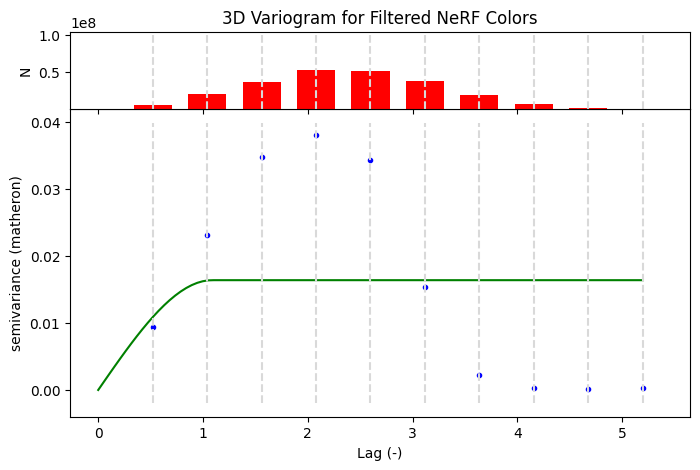

/tmp/ipykernel_349562/2337728267.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('inferno')


: 

In [ ]:
import trimesh
import torch
import mcubes
import numpy as np
from skgstat import Variogram
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist, squareform

device = 'cuda'
pth_file = 'experiments/suzanne/set100/models/M0.pth'
# pth_file = "experiments/test/set30/models/M0.pth"
nerf_model = torch.load(pth_file).to(device)

# Generate the grid of points for XYZ
N = 35
scale = 1.5
x = torch.linspace(-scale, scale, N, device=device)
y = torch.linspace(-scale, scale, N, device=device)
z = torch.linspace(-scale, scale, N, device=device)
x, y, z = torch.meshgrid((x, y, z))
xyz = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)), dim=1)  # [125000, 3] points

# Define a view direction for color queries (e.g., along the z-axis)
view_direction = torch.tensor([0, 0, 1], device=device).expand(xyz.shape[0], -1)

# Query the NeRF model for colors (assumes `forward` outputs RGB and density)
rgb, _ = nerf_model.forward(xyz, view_direction)  # [125000, 3]

# Convert to numpy for processing
xyz = xyz.cpu().detach().numpy()
rgb = rgb.cpu().detach().numpy()

# Apply masking to reduce the number of points
threshold_value = np.quantile(rgb.mean(axis=1), 0.5)  # Use median RGB intensity as threshold
mask = rgb.mean(axis=1) >= threshold_value  # Mask based only on RGB intensity

# Filter points and colors using the mask
filtered_xyz = xyz[mask]
filtered_rgb = rgb[mask]

# Compute the variogram for color
color_variogram = Variogram(
    filtered_xyz, 
    filtered_rgb.mean(axis=1),  # Use mean intensity as a scalar representation of color
    model='spherical', 
    normalize=False, 
    nugget=0.1
)

# Describe the fitted variogram
print(color_variogram.describe())

# Plot the variogram
color_variogram.plot()
plt.title("3D Variogram for Filtered NeRF Colors")
plt.show()

# Compute pairwise distances between points
pairwise_distances = squareform(pdist(filtered_xyz))  # [N, N]

# Get the bin edges and experimental variogram values
bin_edges = color_variogram.bins  # Bin edges (distance ranges)
bin_uncertainties = color_variogram.experimental  # Semi-variance per bin

# Initialize uncertainties for each point
point_uncertainties = np.zeros(filtered_xyz.shape[0])

# Assign uncertainties based on the average bin of the point's neighbors
for i in range(filtered_xyz.shape[0]):
    # Find distances from the current point
    distances = pairwise_distances[i]
    
    # Find which bin each distance falls into
    bin_indices = np.digitize(distances, bin_edges, right=True)
    
    # Assign the uncertainty as the average uncertainty of its neighbors' bins
    neighbor_uncertainties = bin_uncertainties[bin_indices - 1]  # Adjust index
    point_uncertainties[i] = np.mean(neighbor_uncertainties)

# Normalize point uncertainties
point_uncertainties = (point_uncertainties - np.min(point_uncertainties)) / (
    np.max(point_uncertainties) - np.min(point_uncertainties)
)

# Assign colors based on uncertainty using a colormap
colormap = cm.get_cmap('inferno')
colors = colormap(point_uncertainties)[:, :3]  # Get RGB values

# Create a PointCloud with colors
point_cloud = trimesh.points.PointCloud(filtered_xyz, colors=colors)

# Define the uncertainty threshold (e.g., 0.5)
threshold = 0.99

# Filter points, uncertainties, and colors based on the threshold
threshold_mask = point_uncertainties >= threshold  # Keep points with uncertainty >= threshold
filtered_xyz_thresholded = filtered_xyz[threshold_mask]
point_uncertainties_thresholded = point_uncertainties[threshold_mask]
colors_thresholded = colors[threshold_mask]

# Define sphere sizes for the remaining points
sphere_sizes_thresholded = 0.05 + point_uncertainties_thresholded * 0.001
# Create spheres for the thresholded points
spheres = []
for point, size, color in zip(filtered_xyz_thresholded, sphere_sizes_thresholded, colors_thresholded):
    sphere = trimesh.primitives.Sphere(
        radius=size, center=point, subdivisions=2  # Subdivisions for smoothness
    )
    # Apply the color to the sphere
    sphere.visual.vertex_colors = (color * 255).astype(np.uint8)
    spheres.append(sphere)

# Add the spheres and the mesh to the scene
density_np = rgb.mean(axis=1).reshape(N, N, N)  # Example for visualization
vertices, triangles = mcubes.marching_cubes(density_np, 3 * np.mean(density_np))
vertices_scaled = (vertices / N) * (2 * scale) - scale
mesh = trimesh.Trimesh(vertices_scaled, triangles)
scene = trimesh.Scene([mesh] + spheres)

# Show the scene
scene.show()


### Nov 25: experimenting with the variogram

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Generate synthetic point cloud data
np.random.seed(42)

# Region 1: Gaussian with mean 0, variance 1
N1 = 200
points_low_var = np.random.rand(N1, 2) * 50  # Points in lower-left region
values_low_var = np.random.normal(0, 1, N1)  # Scalar values

# Region 2: Gaussian with mean 0, variance 5 (upper-right region)
N2 = 50
points_high_var = np.random.rand(N2, 2) * 20 + 50  # Points in upper-right region
values_high_var = np.random.normal(0, np.sqrt(5), N2)  # Scalar values

# Combine both regions
points = np.vstack([points_low_var, points_high_var])
values = np.hstack([values_low_var, values_high_var])

# Compute pairwise distances
distances = squareform(pdist(points))

# Compute pairwise semi-variance (for values)
semi_variances = np.zeros_like(distances)
for i in range(len(values)):
    for j in range(i + 1, len(values)):
        diff = values[i] - values[j]
        semi_variances[i, j] = (diff ** 2) / 2

# Bin distances into lags
lag_bins = np.linspace(0, np.max(distances), 20)  # 20 bins
bin_indices = np.digitize(distances, lag_bins)
average_semi_variances = [
    semi_variances[bin_indices == i].mean() if np.any(bin_indices == i) else np.nan
    for i in range(len(lag_bins))
]

# Plot the semi-variogram
plt.figure(figsize=(8, 6))
plt.plot(lag_bins[:-1], average_semi_variances[:-1], marker='o', linestyle='-')
plt.xlabel("Lag (Distance)", fontsize=12)
plt.ylabel("Semi-Variance", fontsize=12)
plt.title("Semi-Variogram", fontsize=14)
plt.grid(True)
plt.show()

# Visualize the point cloud and highlight high-variance region
plt.figure(figsize=(8, 6))
plt.scatter(points_low_var[:, 0], points_low_var[:, 1], c='blue', label='Low Variance Region')
plt.scatter(points_high_var[:, 0], points_high_var[:, 1], c='red', label='High Variance Region')
plt.xlabel("X Coordinate", fontsize=12)
plt.ylabel("Y Coordinate", fontsize=12)
plt.title("Spatial Data with High-Variance Region", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Generate synthetic point cloud data
np.random.seed(42)

# Region 1: Gaussian with mean 0, variance 1
N1 = 200
points_low_var = np.random.rand(N1, 2) * 50  # Points in lower-left region
values_low_var = np.random.normal(0, 1, N1)  # Scalar values

# Region 2: Gaussian with mean 0, variance 5 (upper-right region)
N2 = 50
points_high_var = np.random.rand(N2, 2) * 20 + 50  # Points in upper-right region
values_high_var = np.random.normal(0, np.sqrt(5), N2)  # Scalar values

# Combine both regions
points = np.vstack([points_low_var, points_high_var])
values = np.hstack([values_low_var, values_high_var])

# Compute pairwise distances
distances = squareform(pdist(points))

# Compute pairwise semi-variance (for values)
semi_variances = np.zeros_like(distances)
for i in range(len(values)):
    for j in range(i + 1, len(values)):
        diff = values[i] - values[j]
        semi_variances[i, j] = (diff ** 2) / 2

# Scale the semi-variance to the range [0, 1]
scaled_semi_variances = (semi_variances - np.min(semi_variances)) / (
    np.max(semi_variances) - np.min(semi_variances)
)

# Define a threshold for scaled uncertainty
scaled_uncertainty_threshold = 0.7  # Example threshold in the range [0, 1]

# Identify pairs of points with scaled semi-variance above the threshold
high_scaled_variance_indices = np.argwhere(scaled_semi_variances > scaled_uncertainty_threshold)
unique_high_scaled_var_points = set(high_scaled_variance_indices.flatten())

# Extract the points corresponding to high scaled semi-variance
high_scaled_variance_points = points[list(unique_high_scaled_var_points)]

# Plot only the spatial locations above the scaled threshold
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], c='lightgrey', alpha=0.6, label='All Points (Below Threshold)')
plt.scatter(
    high_scaled_variance_points[:, 0],
    high_scaled_variance_points[:, 1],
    c='red',
    alpha=0.8,
    label='High Scaled Variance Points',
)
plt.xlabel("X Coordinate", fontsize=12)
plt.ylabel("Y Coordinate", fontsize=12)
plt.title(f"Spatial Locations Above Scaled Uncertainty Threshold ({scaled_uncertainty_threshold})", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()
